# Computer Problem Set 1.1
## The Cox-Ross-Rubinstein model

### Question 1

#### (a)
We simply return the vector using the formula given in the question :

In [1]:
import numpy as np
from math import sqrt, exp

# We define the value of S0 here, where we use it as a global variable.
# We will change it if necessary.
S0 = 1

def Sn(T, n, b, sigma, j):
    # Define u_n, d_n, h_n
    h_n = T / n
    u_n = exp(b * h_n + sigma * sqrt(h_n))
    d_n = exp(b * h_n - sigma * sqrt(h_n))
    
    # Calculate S_n, which is S_0 * u ** (j - i) * d ** (i) for i = 0,...,j
    S_n = np.zeros(j + 1)
    for i in range(j+1):
        S_n[i] = S0 * u_n ** (j - i) * d_n ** i
    return S_n

#### (b)
We use the possible prices at time $t = T$, where we decide to exercise the option with the strike $K$ when the value is greater than $K$.

In [2]:
def Payoffn(T, n, b, sigma, K):
    possible_prices = Sn(T, n, b, sigma, n)               # At time = T, so j = n
    payoff = (possible_prices - K) * (possible_prices > K) # We take the (S_n(i) - K)+ for the payoff
                                                          # vector of europeen call option
    return payoff

#### (c)
We use the formula in section 2.3 :
$$
price\_call = e^{-rT}\sum_{j = 0}^{n}g(S^n(j))C^{n - j}_nq^{n - j}_n(1-q_n)^{j}
$$
where $g(s) = (s - K)^+$, $C^j_n$ is the combinatory number, $q_n = \frac{e^r - d}{u - d}$.

In generally speaking, it is the actuel value of the expectation of the payoff.

In [3]:
def Calln(T, n, r, b, sigma, K):
    # Define q
    h = T / n
    u = exp(b * h + sigma * sqrt(h))
    d = exp(b * h - sigma * sqrt(h))
    q = (exp(r * T / n) - d) / (u - d)
    
    # The vector of g
    vector_g = Payoffn(T, n, b, sigma, K)
    
    # Init price with 0
    price = 0
    
    # Calculate the sum
    for j in range(n, -1, -1):
        # We update the comb_nb, then apply the formula.
        if j == n:
            comb_nb = 1
        else:
            comb_nb *= (j + 1)
            comb_nb //= (n - j)
        price += vector_g[j] * comb_nb * (q ** (n - j)) * ((1 - q) ** j)
        
    price *= exp(-r * T) # The factor before the sum
    return price

#### (d)
We use this time the formula :
$$
\theta^n_j(\omega_j) = \frac{B^n_{j+1}(\omega_j, u) - B^n_{j+1}(\omega_j, d)}{uS^n_j(\omega_j) - dS^n_j(\omega_j)}
$$
where $B^n_{j+1}(\omega_j, u) = g\left(uS^n_{j}(\omega_j)\right)$, $B^n_{j+1}(\omega_j, d) = g\left(dS^n_{j}(\omega_j)\right)$

We know that $B^n_n$ is equal to the payoff. We are going to calculate it by descending to the root.

In [4]:
def Deltan(T, n, r, b, sigma, K, j):
    # Define the interest rate R and the q the value of (R - d)/(u - d)
    R = exp(r * T / n)
    h = T / n
    u = exp(b * h + sigma * sqrt(h))
    d = exp(b * h - sigma * sqrt(h))
    q = (exp(r * T / n) - d) / (u - d)

    # The payoff at stats n
    index = n
    B_index = Payoffn(T, n, b, sigma, K)

    while index != j + 1:
        index -= 1
        # The asset value : S^n_j
        S_n = Sn(T, n, b, sigma, index)
        # We are going to calculate the B at level index
        B_index = B_index[:-1] * q / R + B_index[1:] * (1 - q) / R
        
        # After a cycle, we get B_index the vector of payoff at moment index
    
    # After "while", we get B_index the payoff at moment j + 1

    S_j = Sn(T, n, b, sigma, j)
    theta_j = (B_index[:-1] - B_index[1:]) / ((u - d) * S_j)

    return theta_j

#### (e)
We first print the Calln in fonction of K

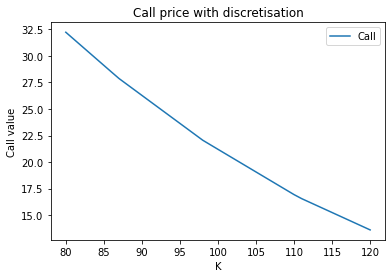

In [5]:
import matplotlib.pyplot as plt
# Initiation
T = 2
n = 50
r = 0.05
b = 0.05
sigma = 0.3
S0 = 100

# Calln values
call_list = [Calln(T, n, r, b, sigma, K) for K in range(80, 121)]

# Plot
plt.plot([K for K in range(80, 121)], call_list, label="Call")
plt.legend(loc="best")
plt.xlabel("K")
plt.ylabel("Call value")
plt.title("Call price with discretisation")
plt.show()

We can see that
* Call is a convex fonction of K
* Call is decreasing in K

We than print the Deltan in fonction of K

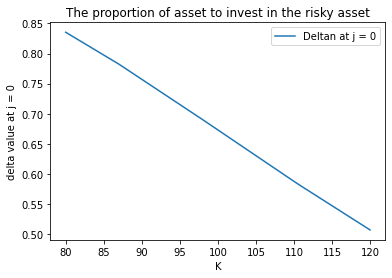

In [6]:
# Deltan values
delta_list = [Deltan(T, n, r, b, sigma, K, 0) for K in range(80, 121)]
# Plot
plt.plot([K for K in range(80,121)], delta_list, label="Deltan at j = 0")
plt.legend(loc="best")
plt.xlabel("K")
plt.ylabel("delta value at j = 0")
plt.title("The proportion of asset to invest in the risky asset")
plt.show()

We found out that :

The proportion of asset to invest in the risky asset S is decreasing to K (Almost linearly)

### Question 2

#### (a)
By the theorem 2.8, we have
$$
p(B) = sN\left(d_+(s, \tilde{K}, \sigma^2T)\right) - \tilde{K}N\left(d_-(s, \tilde{K}, \sigma^2T)\right)
$$
where 
$$
\tilde{K} = Ke^{-rT}, d_{\pm}(s, k, v) = \frac{ln(s/k)}{\sqrt{v}} \pm \frac{\sqrt{v}}{2}
$$
and
N(x) is the cumulative distribution function of standard Gaussian $N(0, 1)$.

In [7]:
from scipy.stats import norm
from math import log

def Call(T, r, sigma, K):
    K_tilde = K * exp(-r * T)
    sqrtsigma2T = sigma * sqrt(T)
    price = S0 * norm.cdf(log(S0 / K_tilde) / sqrtsigma2T + sqrtsigma2T / 2)
    price -= K_tilde * norm.cdf(log(S0 / K_tilde) / sqrtsigma2T - sqrtsigma2T / 2)
    return price

#### (b)
We first imlement the function of *err*.

In [8]:
def err(T, n, r, b, sigma, K):
    return Calln(T, n, r, b, sigma, K) / Call(T, r, sigma, K) - 1

Then, we plot the relatif error in terms of the number of periods n with strike $K = 105$.

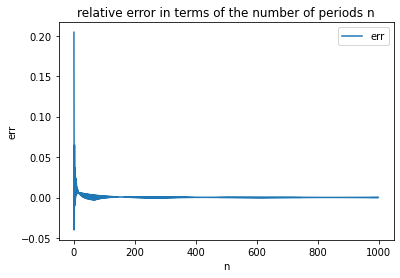

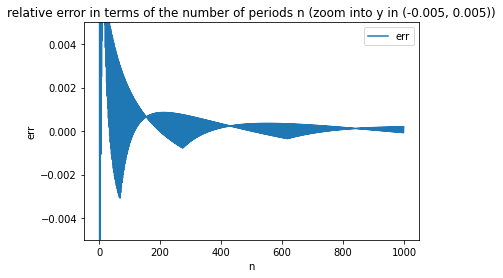

In [9]:
K = 105
upper_bound = 1000
err_list = []
for n in range(1, upper_bound):
    err_list.append(err(T, n, r, b, sigma, K))

# First plot
plt.figure()
plt.plot([i for i in range(1, upper_bound)], err_list, label="err")

plt.xlabel("n")
plt.ylabel("err")
plt.legend(loc="best")
plt.title("relative error in terms of the number of periods n")
plt.show()

# Plot : zoom in to y = -0.005 to y = 0.005
plt.figure()
plt.plot([i for i in range(1, upper_bound)], err_list, label="err")
plt.ylim(-0.005, 0.005)

plt.xlabel("n")
plt.ylabel("err")
plt.legend(loc="best")
plt.title("relative error in terms of the number of periods n (zoom into y in (-0.005, 0.005))")
plt.show()

We found out that the value tends to 0. The Cox-Ross-Rubinstein price coincides with the Black-Scholes formula when n is greater.